# Anexos

Este apartado contiene en detalle el análisis de datos, preprocesamiento, análisis de exploratorio de las variables de interés junto con su explicación. La función de este anexo es de apoyo al texto principal.

## Importación de Librerías

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from haversine import haversine, Unit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from pygam import LinearGAM
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

## A1 - Analisis de datos

El set de datos inicial esta compuesto por cuatros archivos .csv. Los atributos junto con su descripción se presentan a continuación:

__Orden_compra__  
- id_orden : Identificador del pedido de compra.
- Latitud : Dirección de entrega.
- Longitud : Dirección de entrega.
- Dia : Día de la semana en que se prometió la orden
    0: domingo
    1: lunes
    2: martes
    3: miercoles
    4: jueves
    5: viernes
    6: sabado
- Promesa : Hora de entrega prometida al cliente.
- Entrega : Hora en que se entregó el pedido al cliente.
- id_entrega : Si el pedido fue solicitado en “Menos de 90 minutos” o en una ventana horario en el futuro.
- id_recolector : Identificador de la persona que recolectó el pedido.
- id_trasporte : Identificador de la persona que hizo transporte del pedido.
- id_tienda : Identificador del local en que se realizó la compra.
- Tiempo : Tiempo total que demoró completar la orden (desde la compra hasta la entrega).

__Orden_productos__  
- id_orden : Identificador del pedido de compra
- id_productos : Identificador del producto.
- cant_producto : Cantidad solicitada del producto por el cliente.
- cant_encontrada : Cantidad solicitada del producto por el cliente.
- Unidad : Formato en que se vendió el producto (Unidades o KG).

__Recolector__  
- id_recolector : Identificador recolector.
- Clasificación_recolector : Clasificación de experiencia recolector.
- P_aciertos : Porcentaje histórico de productos que el recolector encontró.
- velocidad : Velocidad histórica de recogida de productos.
- P_aceptacion : Porcentaje histórico de pedidos aceptado por el recolector.
- Score_Recolector : Evaluación del recolector.

__Tienda__  
- id_tienda : Identificador de la tienda.
- tienda : Identificador de la tienda a la cual pertenece de la tienda.
- latitud_tienda : Latitud de la ubicación de la tienda.
- Longitud_tienda : Longitud de la ubicación de la tienda.

### A1.1 - Compra

In [2]:
compra = pd.read_csv('data/1_Orden_compra.csv', sep=';')
compra.head()

,order_id,lat,lng,dow,promised_time,actual_time,on_demand,picker_id,driver_id,store_branch_id,total_minutes
0,6abd5e28d01b7c733fe37485294235dc,1.822.114.109.606.680,-10.031.391.366.664.600,2,13:00:00,12:00:15,False,09bb5bfe76adbb474dddbdd111a51623,09bb5bfe76adbb474dddbdd111a51623,0dc6fb5924a8b917bc641666ed02663c,91.800.861
1,0d37a1eea001f01b40232ffd496ff663,18.177.712.202.580.300,-10.035.705.073.096.900,2,13:00:00,10:28:10,False,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,206.599.732
2,528428e9b9eb5d3bd0dbdd8da692b087,1.826.683.205.404.410,-10.031.755.280.890.600,2,11:00:00,10:40:50,False,e15c7a67d0ea9a54dffb410bc1d8528b,e15c7a67d0ea9a54dffb410bc1d8528b,8d891dfc0e29d744c15c18adced74a68,93.458.001
3,d3f7be6d64eae7405b7bf024e04807a2,18.248.884.004.419.400,-1.003.226.215.187.040,2,10:00:00,9:41:47,False,d1f0bd4b237c1358f09db22076b940e7,d1f0bd4b237c1358f09db22076b940e7,0dc6fb5924a8b917bc641666ed02663c,124.778.761
4,e0ad6533b6cd9a382ec6c1d473c5036c,1.822.911.027.242.010,-10.032.267.241.783.800,2,11:00:00,10:07:53,False,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,130.321.208


In [3]:
#Variable categorica
compra['on_demand'].value_counts()

False    4225
True     3070
Name: on_demand, dtype: int64

In [4]:
#Se recodifica el atributo Booleano
compra['on_demand'] = np.where(compra['on_demand'] == False, 1, 0)

In [5]:
compra['on_demand'].value_counts()

1    4225
0    3070
Name: on_demand, dtype: int64

In [6]:
#Se actualizan los nombres de los atributos en el dataset
compra.rename(columns={'order_id':'id_orden', 'lat':'latitud', 'lng':'longitud', 'dow':'dia', 'promised_time':'promesa',
                       'actual_time':'entrega', 'on_demand':'id_entrega', 'picker_id':'id_recolector', 
                       'driver_id':'id_transporte', 'store_branch_id':'id_tienda', 'total_minutes':'tiempo'}, inplace=True)

In [7]:
print("La cantidad de registros es de:", compra.shape[0])
print("La cantidad de atributos es de:", compra.shape[1])

La cantidad de registros es de: 7295
La cantidad de atributos es de: 11


In [8]:
#Se hace una tabla para observar los missing values
total = compra.isnull().sum().sort_values(ascending=False)
percent = round((compra.isnull().sum() / compra.isnull().count()) * 100, 2).sort_values(ascending=False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje (%)'])
missing_values

,Total,Porcentaje (%)
tiempo,752,10.31
id_tienda,0,0.00
id_transporte,0,0.00
id_recolector,0,0.00
id_entrega,0,0.00
entrega,0,0.00
promesa,0,0.00
dia,0,0.00
longitud,0,0.00
latitud,0,0.00


Se puede apreciar que en este dataset sólo el atributo `tiempo` contiene datos perdidos, con un monto de __752__ registros, los cuales representan el __10.31%__ de la data, por tal motivo se hará una eliminación de dichos datos, el motivo es que este atributo es nuestra variable objetivo y no queremos que se vea afectada por ningún motivo.

In [9]:
compra.dropna(inplace=True)

In [10]:
print("La cantidad de registros es de:", compra.shape[0])
print("La cantidad de atributos es de:", compra.shape[1])

La cantidad de registros es de: 6543
La cantidad de atributos es de: 11


### A1.2 - Productos

In [11]:
productos = pd.read_csv('data/2_Orden_productos.csv', sep=';')
productos.head()

,order_id,product_id,quantity,quantity_found,buy_unit
0,bdfc44fb525986b7bab8c589fc47e853,ab9757d9892b0e83ab3a1c1af0c84c52,0.75,0.155,KG
1,bdfc44fb525986b7bab8c589fc47e853,f1f042251bf634d44f338fbaf13b16e4,0.3,0.400,KG
2,bdfc44fb525986b7bab8c589fc47e853,0630d47440965509b0b3f80fd1b3578f,1,1.000,UN
3,bdfc44fb525986b7bab8c589fc47e853,9dd69b1f300666d5573e3a9934f2e03e,2,2.000,UN
4,bdfc44fb525986b7bab8c589fc47e853,3dfcdbe308bde67370649dd875f2507b,1,1.000,UN


In [12]:
#Se actualiza el nombre del atributo que identifica la orden de compra
productos.rename(columns={'order_id':'id_orden'}, inplace=True)

In [13]:
print("La cantidad de registros es de:", productos.shape[0])
print("La cantidad de atributos es de:", productos.shape[1])

La cantidad de registros es de: 120876
La cantidad de atributos es de: 5


No se encontraron datos perdidos en este dataset.

In [14]:
productos.isnull().any()

id_orden          False
product_id        False
quantity          False
quantity_found    False
buy_unit          False
dtype: bool

Se procederá a separar aquellos productos que se pesan y se contabilizan como 1, los que son por unidad mantendremos la cantidad. 
El objetivo de esta segmentación es posteriormente tener una columna de productos que son pesado y otras que son por unidad, ya que para este caso sólo nos importa la cantidad total de productos (pesados y por unidad) por orden, si bien tenemos un código de producto por el momento no podremos determinar el tipo de producto, si tendríamos esa información disponible podríamos determinar que productos que son pesados pueden influenciar más o menos en el tiempo de entrega, así que, nos concentraremos en la cantidad de productos por orden.

In [15]:
#Creamos una columna de tipo bandera, para determinar que las cantidades que están en el atributo quantity,
#correspondan con su respectiva unidad
productos['cantidad_ajustada'] = np.where(productos['buy_unit'] == 'KG' , 1, productos['quantity'])
productos['cantidad_ajustada'] = pd.to_numeric(productos['cantidad_ajustada'])

Para este caso cuando se evaluó la columna de "tipo bandera"--> `cantidad_ajustada`, se pudo apreciar que teníamos 2 casos anómalos ya que acá todos los valores tenían que ser entero y descubrimos que existen 2 casos donde en la columna `quantity` hay valores decimales y en la columna `buy_unit` su valor es __UN__ representando esto como Unidad, cuando en realidad es de tipo __KG__, se prodecerá a actualizar estos registros y volver a actualizar la columna `cantidad_ajustada`.

In [16]:
no_KG = productos.loc[(productos['cantidad_ajustada'] == 0.225) | (productos['cantidad_ajustada'] == 0.090)]
no_KG.head()

,id_orden,product_id,quantity,quantity_found,buy_unit,cantidad_ajustada
29253,7a1be969ec97b66b710f7dc5b80f8a6f,068566a7b65d4093075f13ae383aa3d4,0.09,0.090,UN,0.090
96244,a5fc3ba3db31ac6a1ea5ddb87dcbc596,e0922ceeaeb05c556c27138d10305932,0.225,0.225,UN,0.225


Existen par de productos que en la __unidad de compra__ marcan como __"UN"__ cuando en realidad son de tipo __"KG"__.

In [17]:
#Se reemplazan esos valores por los verdaderos
productos.loc[29253, 'buy_unit'] = 'KG'
productos.loc[96244, 'buy_unit'] = 'KG'

In [18]:
#Se actualizan los datos
productos['cantidad_ajustada'] = np.where(productos['buy_unit'] == 'KG' , 1, productos['quantity'])
productos['cantidad_ajustada'] = pd.to_numeric(productos['cantidad_ajustada'])

Separamos en tipo de productos: Aquellos que se pesan y aquellos que no, además, crearemos una columna extra que será la cantidad total, conformada por la suma entre los productos sin pesar con los que se pesan.

In [19]:
tipo = pd.get_dummies(productos['buy_unit'])

In [20]:
productos['sin_pesar'] = tipo['UN']
productos['pesados'] = tipo ['KG']
productos['cantidad_total'] = productos['sin_pesar'] + productos['pesados']
productos.drop(columns=['quantity', 'quantity_found', 'buy_unit', 'product_id', 'cantidad_ajustada'], inplace=True)

In [21]:
productos_agrupados = productos.groupby(by='id_orden').sum().reset_index()

In [22]:
productos_agrupados.head()

,id_orden,sin_pesar,pesados,cantidad_total
0,001ef94c50c71cb0e674b6293e9b6068,30,5,35
1,001f7583bb106a338d09a12a89e54cbd,5,0,5
2,002b6dcb32fef90ebb1cb691afe6a413,9,0,9
3,002ebc46f3e40c49044aceb8311df432,3,1,4
4,002f97bd7dad0d275d8511436c18b572,7,4,11


Finalmente, se hizo una agrupación del dataframe por número de orden, así consideramos solamente los productos que son pesado y los que no son pesados y la suma total de ellos.

### A1.3 - Recolector

In [23]:
recolector = pd.read_csv('data/3_Recolector.csv', sep=";")
recolector.head()

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,087ab65ceca40dbef697f585dc159d5d,ADVANCED,0.8610,1.64,1.00,4.48
1,645973c41314d763b58dc2bceeeeffc9,INTERMEDIATE,0.8337,2.83,0.96,4.79
2,82810715fdda44962e7e422015ea1f32,ADVANCED,0.8681,1.27,0.88,4.84
3,416aa7dbd5a2f58d7bca96657e8faa1e,INTERMEDIATE,0.8784,2.11,1.00,NaN
4,27a3e845a4c3eb7ded4748f84140a843,ADVANCED,0.8466,1.50,1.00,4.84


In [24]:
print("La cantidad de registros es de:", recolector.shape[0])
print("La cantidad de atributos es de:", recolector.shape[1])

La cantidad de registros es de: 600
La cantidad de atributos es de: 6


In [25]:
#Se renombran las columnas del dataset
recolector.rename(columns={'shopper_id':'id_recolector', 'seniority':'clasificacion_recolector', 
                           'found_rate':'p_aciertos', 'picking_speed':'velocidad', 
                           'accepted_rate':'p_aceptacion', 'rating':'score_recolector'}, inplace=True)

Tenemos algunos datos perdidos en el dataset por lo que determinaremos la cantidad que representa cada atributo para posteriormente aislar estos casos y analizarlos de una mejor manera.

In [26]:
recolector.isnull().any()

id_recolector               False
clasificacion_recolector    False
p_aciertos                   True
velocidad                   False
p_aceptacion                 True
score_recolector             True
dtype: bool

In [27]:
total = recolector.isnull().sum().sort_values(ascending=False)
percent = round((recolector.isnull().sum() / recolector.isnull().count()) * 100, 2).sort_values(ascending=False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje (%)'])
missing_values

,Total,Porcentaje (%)
p_aciertos,36,6.00
score_recolector,34,5.67
p_aceptacion,6,1.00
velocidad,0,0.00
clasificacion_recolector,0,0.00
id_recolector,0,0.00


Podemos apreciar que existen __3 atributos__ los cuales tienen algunos datos perdidos, donde se representa en porcentaje la cifra de ellos en c/u. No vamos a eliminarlos hasta cruzar este dataset con los otros y tener el consolidado.

Para este caso tenemos pocos atributos en nuestro dataset, por lo que emplearemos la técnica `get_dummies` para separar y convertir en nuevos atributos la columna `clasificacion_recolector`, la cual representa la clasificación del recolector y para este caso tenemos sólo __4 tipos__.

In [28]:
#Se contabilizan las categorías del atributo 'clasificacion_recolector'
recolector['clasificacion_recolector'].value_counts()

ADVANCED        268
INTERMEDIATE    204
REVIEW           99
BEGINNER         29
Name: clasificacion_recolector, dtype: int64

In [29]:
recolector['seniority_copy'] = recolector['clasificacion_recolector']
recolector = pd.get_dummies(recolector, columns=['clasificacion_recolector'], prefix='seniority', prefix_sep='_', 
                            drop_first=True)

In [30]:
recolector.head()

,id_recolector,p_aciertos,velocidad,p_aceptacion,score_recolector,seniority_copy,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW
0,087ab65ceca40dbef697f585dc159d5d,0.8610,1.64,1.00,4.48,ADVANCED,0,0,0
1,645973c41314d763b58dc2bceeeeffc9,0.8337,2.83,0.96,4.79,INTERMEDIATE,0,1,0
2,82810715fdda44962e7e422015ea1f32,0.8681,1.27,0.88,4.84,ADVANCED,0,0,0
3,416aa7dbd5a2f58d7bca96657e8faa1e,0.8784,2.11,1.00,NaN,INTERMEDIATE,0,1,0
4,27a3e845a4c3eb7ded4748f84140a843,0.8466,1.50,1.00,4.84,ADVANCED,0,0,0


In [31]:
recolector.rename(columns={'seniority_copy':'clasificacion_recolector'}, inplace=True)

### A1.4 - Tiendas

In [32]:
tienda = pd.read_csv('data/4_tienda.csv', sep=';')
tienda.head()

,store_branch_id,store,lat,lng
0,cf0895f1e3beb8164f0a86e6f940ae56,c0b93cf93cf854981b8d6bd849eec4b0,18.160.308.413.602.800,-10.026.067.265.111.100
1,3ddd4c29cab4178d89d549c6ba65c236,044d56734d20e04984d846dade6d39f3,1.827.282.968.914.450,-10.031.881.435.593.900
2,e9763f24fd46d0b9e52d423207a87c3c,452ae015bf846e1d2932b7ea15720d64,18.273.494.015.704.800,-10.031.958.539.978.200
3,49b7d60d6095a9f1129ce798102b62f4,6447951cd071f6f045fd4e6194920926,1.824.774.341.566.610,-10.040.355.771.938.600
4,8f21cfda17b340aeee062220d0bee8e5,452ae015bf846e1d2932b7ea15720d64,18.203.111.495.565.700,-10.029.771.361.550.100


Podemos apreciar que no tenemos datos perdidos en el dataset.

In [33]:
tienda.isnull().any()

store_branch_id    False
store              False
lat                False
lng                False
dtype: bool

In [34]:
print("La cantidad de registros es de:", tienda.shape[0])
print("La cantidad de atributos es de:", tienda.shape[1])

La cantidad de registros es de: 113
La cantidad de atributos es de: 4


In [35]:
#Se renombran las columnas del dataset
tienda.rename(columns={'store_branch_id':'id_tienda', 'store':'tienda', 'lat':'latitud_tienda',
                       'lng':'longitud_tienda'}, inplace=True)

### A1.5 - Consolidación

In [36]:
#Consolidación de los df compra y prodructos
df = pd.merge(compra, productos_agrupados, how='left', on='id_orden')

In [37]:
#Consolidación del df con recolector
df = pd.merge(df, recolector, how='left', on='id_recolector')

In [38]:
#consolidación de todos los dataset
df = pd.merge(df, tienda, how='left', on='id_tienda')

In [39]:
print("La cantidad de registros final es de:", df.shape[0])
print("La cantidad de atributos final es de:", df.shape[1])

La cantidad de registros final es de: 6543
La cantidad de atributos final es de: 25


In [40]:
df.to_csv('data/consolidado.csv', header=True, index=False)

Tenemos nuestro dataset consolidado, vamos a proceder a evaluarlo para determinar si hay casos con datos perdidos y/o anómalos, posteriormente se aplicarán más técnicas de recodificación para dejar limpio en su totalidad.

In [41]:
df.head()

,id_orden,latitud,longitud,dia,promesa,entrega,id_entrega,id_recolector,id_transporte,id_tienda,...,velocidad,p_aceptacion,score_recolector,clasificacion_recolector,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW,tienda,latitud_tienda,longitud_tienda
0,6abd5e28d01b7c733fe37485294235dc,1.822.114.109.606.680,-10.031.391.366.664.600,2,13:00:00,12:00:15,1,09bb5bfe76adbb474dddbdd111a51623,09bb5bfe76adbb474dddbdd111a51623,0dc6fb5924a8b917bc641666ed02663c,...,1.56,1.00,4.68,ADVANCED,0,0,0,60e4c4e1c1a8bc79123738227b9d0b08,1.823.190.132.492.320,-1.003.035.533.737.440
1,0d37a1eea001f01b40232ffd496ff663,18.177.712.202.580.300,-10.035.705.073.096.900,2,13:00:00,10:28:10,1,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,...,1.14,1.00,4.76,ADVANCED,0,0,0,387d4a5b65cf4bf00ad805c4b00eed01,18.163.960.871.027.900,-10.032.899.405.911.000
2,528428e9b9eb5d3bd0dbdd8da692b087,1.826.683.205.404.410,-10.031.755.280.890.600,2,11:00:00,10:40:50,1,e15c7a67d0ea9a54dffb410bc1d8528b,e15c7a67d0ea9a54dffb410bc1d8528b,8d891dfc0e29d744c15c18adced74a68,...,2.03,1.00,4.96,INTERMEDIATE,0,1,0,0fae7b61265bc7ca4ce4d81440b62501,1.824.565.541.228.880,-1.003.324.934.760.470
3,d3f7be6d64eae7405b7bf024e04807a2,18.248.884.004.419.400,-1.003.226.215.187.040,2,10:00:00,9:41:47,1,d1f0bd4b237c1358f09db22076b940e7,d1f0bd4b237c1358f09db22076b940e7,0dc6fb5924a8b917bc641666ed02663c,...,2.06,0.92,4.92,INTERMEDIATE,0,1,0,60e4c4e1c1a8bc79123738227b9d0b08,1.823.190.132.492.320,-1.003.035.533.737.440
4,e0ad6533b6cd9a382ec6c1d473c5036c,1.822.911.027.242.010,-10.032.267.241.783.800,2,11:00:00,10:07:53,1,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,...,1.89,1.00,4.92,ADVANCED,0,0,0,452ae015bf846e1d2932b7ea15720d64,1.823.159.108.764.060,-10.031.450.001.698.800


Existen datos perdidos en el dataset consolidado,vamos a calcular la cantidad en cada atributo, se mostrarán dichos datos en una tabla.

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6543 entries, 0 to 6542
Data columns (total 25 columns):
id_orden                    6543 non-null object
latitud                     6543 non-null object
longitud                    6543 non-null object
dia                         6543 non-null int64
promesa                     6543 non-null object
entrega                     6543 non-null object
id_entrega                  6543 non-null int64
id_recolector               6543 non-null object
id_transporte               6543 non-null object
id_tienda                   6543 non-null object
tiempo                      6543 non-null object
sin_pesar                   6528 non-null float64
pesados                     6528 non-null float64
cantidad_total              6528 non-null float64
p_aciertos                  6468 non-null float64
velocidad                   6543 non-null float64
p_aceptacion                6538 non-null float64
score_recolector            6473 non-null float64
clasif

Antes de pasar a realizar nuestro análisis exploratorio y posteriormente el descriptivo, terminaremos de recodificar ciertas variables en nuestro dataset para así asegurar la legibilidad de los datos al momento de implementar la modelación de ellos. En esta ocasión nuestro dataset consolidado está constituido por __latitudes y longitudes__ tanto de los pedidos como de las tiendas, acá vamos a trabajar con la distancia que se genera entre ellos, aplicando una transformación con la librería `haversine`, el resultado nos dará automáticamente en __Kilometros__ ya que viene por defecto en dicha librería.

In [43]:
#Se crea un dataframe temporal para calcular la distancia
distancias = pd.DataFrame()

distancias['latitud_x'] = pd.to_numeric(df['latitud'].str.replace('.',''))*100/(10**(df['latitud'].str.replace('.','').apply(len)))
distancias['longitud_x'] = (pd.to_numeric(df['longitud'].str.replace('.',''))/(10**(df['longitud'].str.replace('.','').apply(len)))) * 1000

distancias['latitud_y'] = pd.to_numeric(df['latitud_tienda'].str.replace('.',''))*100/(10**(df['latitud_tienda'].str.replace('.','').apply(len)))
distancias['longitud_y'] = (pd.to_numeric(df['longitud_tienda'].str.replace('.',''))/(10**(df['longitud_tienda'].str.replace('.','').apply(len)))) * 1000

df['distancia']= distancias.apply(lambda x: haversine((x['latitud_x'], x['longitud_x']),(x['latitud_y'], x['longitud_y'])), axis=1)

Aislamos los datos que tienen un tiempo menor a 25 minutos, para mantener una distribución normal en los datos, esto con el objetivo de hacer una comparación en los resultados que tanto puede afectar las ordenes de compra con dicho tiempo. Estos datos con esta característica en particular son de una cantidad de __657 registros__.

In [44]:
#Extendemos la vista de las columnas o atributos del dataframe
pd.set_option('display.max_columns', 100)

In [45]:
#Convertimos la variable tiempo a minutos
df['tiempo'] = pd.to_numeric(df.tiempo.str.replace('.',''))/1000000

In [46]:
#Creamos un dataframe con el tiempo menor a 25 minutos para tener una distribución casi normal y 
#modelar sin ellos para posteriormente realizar un análisis
p_anomalos = df[df['tiempo'] < 25]

In [47]:
p_anomalos.head()

,id_orden,latitud,longitud,dia,promesa,entrega,id_entrega,id_recolector,id_transporte,id_tienda,tiempo,sin_pesar,pesados,cantidad_total,p_aciertos,velocidad,p_aceptacion,score_recolector,clasificacion_recolector,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW,tienda,latitud_tienda,longitud_tienda,distancia
8,c1800bdd3c666b497b39d6e526917167,18.220.946.960.795.100,-10.041.727.333.923.400,2,10:00:00,8:46:04,1,a083ea904c55052cdb58917ed790ca96,a083ea904c55052cdb58917ed790ca96,2d69acabaafd2516eeffd3c69b3c1328,0.665212,19.0,1.0,20.0,0.8556,1.50,0.96,4.72,ADVANCED,0,0,0,60e4c4e1c1a8bc79123738227b9d0b08,18.218.347.218.797.100,-10.041.579.255.293.500,0.289501
12,df5de78cdde5a1fcd3ab2e1854a4b7a0,1.826.850.386.845.330,-10.031.256.569.770.200,2,12:00:00,11:36:23,1,91b508d81eb559e384062d1c046594b9,91b508d81eb559e384062d1c046594b9,8d891dfc0e29d744c15c18adced74a68,1.533419,17.0,3.0,20.0,0.8652,2.43,1.00,5.00,INTERMEDIATE,0,1,0,0fae7b61265bc7ca4ce4d81440b62501,1.824.565.541.228.880,-1.003.324.934.760.470,2.549336
27,605db8da3965581ea0bf6d56082600bf,18.245.512.889.554.400,-10.040.992.084.939.800,2,10:00:00,8:41:50,1,b7e1166967f3ad4aa76d6090cf099f80,b7e1166967f3ad4aa76d6090cf099f80,afab9a94cf9d3d20ba7192204d5e48b3,5.329401,9.0,0.0,9.0,0.8519,1.69,1.00,4.92,ADVANCED,0,0,0,60e4c4e1c1a8bc79123738227b9d0b08,1.826.087.441.600.350,-1.004.115.704.253.060,1.708215
28,e1d9a4f57ffe610c5fb453a0ab350ea0,18.245.506.201.052.900,-10.041.015.840.731.400,2,10:00:00,8:44:07,1,056c7cc586dece322e35970ee60234da,056c7cc586dece322e35970ee60234da,7a44728dc60bafc53140a9f5ef7e4e75,4.281824,1.0,0.0,1.0,0.8272,2.07,1.00,4.88,INTERMEDIATE,0,1,0,451eb58b96f0a36f31d2beebd1c9a7a8,18.265.531.115.122.400,-10.041.410.817.239.000,2.227063
52,b145ee8b457318dc87e334379e9e61f7,1.822.428.085.969.520,-10.041.237.791.251.600,2,11:00:00,10:51:25,1,8b59adedc5c1ea8defcc5e970fae8322,8b59adedc5c1ea8defcc5e970fae8322,3dd9ae393aa5327edfb27388758436bd,9.662399,4.0,0.0,4.0,0.8471,1.50,1.00,4.64,ADVANCED,0,0,0,0fae7b61265bc7ca4ce4d81440b62501,1.826.223.164.590.900,-1.004.150.072.862.420,4.220032


Tenemos un total de 657 registros que tienen tiempo menor igual a 25 minutos, procederemos a eliminarlos.

In [48]:
print("La cantidad de registros es de:", p_anomalos.shape[0])
print("La cantidad de atributos es de:", p_anomalos.shape[1])

La cantidad de registros es de: 657
La cantidad de atributos es de: 26


In [49]:
#Se hace una copia del dataframe primero, debido a que este nuevo dataframe se harán las imputaciones de
#atributos y evaluarlo en nuestros modelos posteriormente también.
df_imputados = df.copy()

In [50]:
#Se eliminan los registros con un tiempo menor a 25 minutos
df.drop( df[ df['tiempo'] < 25 ].index , inplace=True)

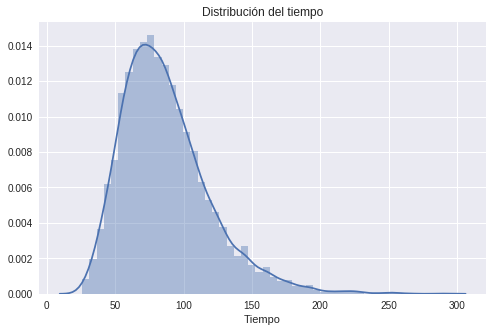

In [51]:
plt.figure(figsize=(8, 5))
sns.distplot(df['tiempo'])
plt.xlabel("Tiempo")
plt.title("Distribución del tiempo");

Acá podremos observar la cantidad de datos perdidos por atributo y cuanto significa cada uno de ellos en porcentaje; tenemos 6 atributos con datos perdidos, para este caso vamos a imputar 3 de ellos `p_aciertos, score_recolector y p_aceptacion`, la imputación se hará rellenando los valores perdidos con la media de la columna, para efecto en el modelamiento no tendrá ninguno ya que los valores de los registros están concentrados en esa área y no afectaría de manera relevante, además, salvaríamos esos datos para obtener un mejor resultado. A continuación, se detalla el proceso de cada variable:

In [52]:
total = df.isnull().sum().sort_values(ascending=False)
percent = round((df.isnull().sum() / df.isnull().count()) * 100, 2).sort_values(ascending=False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje (%)'])
missing_values

,Total,Porcentaje (%)
p_aciertos,66,1.12
score_recolector,63,1.07
pesados,13,0.22
cantidad_total,13,0.22
sin_pesar,13,0.22
p_aceptacion,5,0.08
id_tienda,0,0.00
latitud,0,0.00
longitud,0,0.00
dia,0,0.00


In [53]:
#Eliminación de los datos perdidos para trabajar con el dataset sin imputar
df.dropna(inplace=True)

In [54]:
df.isnull().any()

id_orden                    False
latitud                     False
longitud                    False
dia                         False
promesa                     False
entrega                     False
id_entrega                  False
id_recolector               False
id_transporte               False
id_tienda                   False
tiempo                      False
sin_pesar                   False
pesados                     False
cantidad_total              False
p_aciertos                  False
velocidad                   False
p_aceptacion                False
score_recolector            False
clasificacion_recolector    False
seniority_BEGINNER          False
seniority_INTERMEDIATE      False
seniority_REVIEW            False
tienda                      False
latitud_tienda              False
longitud_tienda             False
distancia                   False
dtype: bool

In [55]:
#Eliminamos las columnas sin relevancia
df.drop(columns=['id_orden', 'latitud', 'longitud', 'id_entrega', 'id_recolector', 'id_transporte', 
                 'id_tienda', 'tienda', 'latitud_tienda', 'longitud_tienda', 'clasificacion_recolector'], 
        inplace=True)

### Dataset para modelar sin imputaciones

In [56]:
#Dataset modelamiento sin imputaciones
df_sin_imputaciones = df.copy()

#Dejar atributo día mientras tanto para posterior análisis exploratorio
df_sin_imputaciones['dia_copy'] = df_sin_imputaciones['dia']

#one-hot-enconding al atributo dia
df_sin_imputaciones = pd.get_dummies(df_sin_imputaciones, prefix='dia', prefix_sep='_', columns=['dia'], 
                                     drop_first=True)

#Se renombran ciertas columnas del dataframe
df_sin_imputaciones.rename(columns={'dia_copy':'dia', 'dia_1':'lunes', 'dia_2':'martes', 'dia_3':'miercoles',
                                 'dia_4':'jueves', 'dia_5':'viernes', 'dia_6':'sabado'}, inplace=True)


df_sin_imputaciones.head()

,promesa,entrega,tiempo,sin_pesar,pesados,cantidad_total,p_aciertos,velocidad,p_aceptacion,score_recolector,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW,distancia,dia,lunes,martes,miercoles,jueves,viernes,sabado
0,13:00:00,12:00:15,91.800861,17.0,10.0,27.0,0.8564,1.56,1.00,4.68,0,0,0,1.201478,2,0,1,0,0,0,0
1,13:00:00,10:28:10,206.599732,88.0,15.0,103.0,0.8516,1.14,1.00,4.76,0,0,0,1.557546,2,0,1,0,0,0,0
2,11:00:00,10:40:50,93.458001,6.0,0.0,6.0,0.8337,2.03,1.00,4.96,0,1,0,2.360018,2,0,1,0,0,0,0
3,10:00:00,9:41:47,124.778761,12.0,5.0,17.0,0.8571,2.06,0.92,4.92,0,1,0,1.899097,2,0,1,0,0,0,0
4,11:00:00,10:07:53,130.321208,28.0,16.0,44.0,0.8625,1.89,1.00,4.92,0,0,0,0.289042,2,0,1,0,0,0,0


### Dataset para modelar con imputaciones

In [57]:
df_imputados.head()

,id_orden,latitud,longitud,dia,promesa,entrega,id_entrega,id_recolector,id_transporte,id_tienda,tiempo,sin_pesar,pesados,cantidad_total,p_aciertos,velocidad,p_aceptacion,score_recolector,clasificacion_recolector,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW,tienda,latitud_tienda,longitud_tienda,distancia
0,6abd5e28d01b7c733fe37485294235dc,1.822.114.109.606.680,-10.031.391.366.664.600,2,13:00:00,12:00:15,1,09bb5bfe76adbb474dddbdd111a51623,09bb5bfe76adbb474dddbdd111a51623,0dc6fb5924a8b917bc641666ed02663c,91.800861,17.0,10.0,27.0,0.8564,1.56,1.00,4.68,ADVANCED,0,0,0,60e4c4e1c1a8bc79123738227b9d0b08,1.823.190.132.492.320,-1.003.035.533.737.440,1.201478
1,0d37a1eea001f01b40232ffd496ff663,18.177.712.202.580.300,-10.035.705.073.096.900,2,13:00:00,10:28:10,1,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,206.599732,88.0,15.0,103.0,0.8516,1.14,1.00,4.76,ADVANCED,0,0,0,387d4a5b65cf4bf00ad805c4b00eed01,18.163.960.871.027.900,-10.032.899.405.911.000,1.557546
2,528428e9b9eb5d3bd0dbdd8da692b087,1.826.683.205.404.410,-10.031.755.280.890.600,2,11:00:00,10:40:50,1,e15c7a67d0ea9a54dffb410bc1d8528b,e15c7a67d0ea9a54dffb410bc1d8528b,8d891dfc0e29d744c15c18adced74a68,93.458001,6.0,0.0,6.0,0.8337,2.03,1.00,4.96,INTERMEDIATE,0,1,0,0fae7b61265bc7ca4ce4d81440b62501,1.824.565.541.228.880,-1.003.324.934.760.470,2.360018
3,d3f7be6d64eae7405b7bf024e04807a2,18.248.884.004.419.400,-1.003.226.215.187.040,2,10:00:00,9:41:47,1,d1f0bd4b237c1358f09db22076b940e7,d1f0bd4b237c1358f09db22076b940e7,0dc6fb5924a8b917bc641666ed02663c,124.778761,12.0,5.0,17.0,0.8571,2.06,0.92,4.92,INTERMEDIATE,0,1,0,60e4c4e1c1a8bc79123738227b9d0b08,1.823.190.132.492.320,-1.003.035.533.737.440,1.899097
4,e0ad6533b6cd9a382ec6c1d473c5036c,1.822.911.027.242.010,-10.032.267.241.783.800,2,11:00:00,10:07:53,1,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,130.321208,28.0,16.0,44.0,0.8625,1.89,1.00,4.92,ADVANCED,0,0,0,452ae015bf846e1d2932b7ea15720d64,1.823.159.108.764.060,-10.031.450.001.698.800,0.289042


Tenemos datos perdidos en nuestro dataset, vamos a imputar ciertas variables para no eliminar registros, posteriormente haremos nuestra modelación y compararemos.

In [58]:
total = df_imputados.isnull().sum().sort_values(ascending=False)
percent = round((df_imputados.isnull().sum() / df_imputados.isnull().count()) * 100, 2).sort_values(ascending=False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje (%)'])
missing_values

,Total,Porcentaje (%)
p_aciertos,75,1.15
score_recolector,70,1.07
pesados,15,0.23
cantidad_total,15,0.23
sin_pesar,15,0.23
p_aceptacion,5,0.08
id_tienda,0,0.00
latitud,0,0.00
longitud,0,0.00
dia,0,0.00


#### Imputación de los atributos

Imputaremos los datos perdidos de los siguientes atributos: `p_aciertos, p_aceptacion, score_recolector, pesados y sin_pesar` por la media del atributo con respecto a la categoría de `clasificacion_recolector`.

In [59]:
#Aislamos los datos nulos del atributo
p_aciertos = df_imputados[df_imputados['p_aciertos'].isnull()]

In [60]:
#Verificamos cuales son las categorías del atributo de la clasificación del recolector
#para luego hacer la imputación a ellos
p_aciertos.clasificacion_recolector.value_counts()

BEGINNER        53
REVIEW          18
INTERMEDIATE     4
Name: clasificacion_recolector, dtype: int64

In [61]:
#Obtenemos la media de p_aciertos por categoría del recolector
media_cr = df_imputados.groupby('clasificacion_recolector')['p_aciertos'].mean()
media_cr

clasificacion_recolector
ADVANCED        0.863677
BEGINNER        0.836530
INTERMEDIATE    0.849510
REVIEW          0.828049
Name: p_aciertos, dtype: float64

In [62]:
#Hacemos la imputación de los datos perdidos de p_aciertos con la media del atributo con respecto 
#a la categoría 

df_imputados['p_aciertos'] = np.where((df_imputados['clasificacion_recolector'] == 'BEGINNER') & 
                                      (df_imputados['p_aciertos'].isnull()), 0.836530, df_imputados['p_aciertos'])

df_imputados['p_aciertos'] = np.where((df_imputados['clasificacion_recolector'] == 'REVIEW') & 
                                      (df_imputados['p_aciertos'].isnull()), 0.828049, df_imputados['p_aciertos'])

df_imputados['p_aciertos'] = np.where((df_imputados['clasificacion_recolector'] == 'INTERMEDIATE') & 
                                      (df_imputados['p_aciertos'].isnull()), 0.849510, df_imputados['p_aciertos'])

In [63]:
#Aislamos los casos de p_aceptacion
p_aceptacion = df_imputados[df_imputados['p_aceptacion'].isnull()]
p_aceptacion.head()

,id_orden,latitud,longitud,dia,promesa,entrega,id_entrega,id_recolector,id_transporte,id_tienda,tiempo,sin_pesar,pesados,cantidad_total,p_aciertos,velocidad,p_aceptacion,score_recolector,clasificacion_recolector,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW,tienda,latitud_tienda,longitud_tienda,distancia
532,fdd5ba893f325dd8f21a14717261ff4c,18.177.901.456.272.600,-10.036.665.946.228.000,2,20:00:00,19:39:23,1,22d1884f71a7cd382d9972186548c687,22d1884f71a7cd382d9972186548c687,ea19343a1b5262c624347d89cc17aa9e,111.746763,10.0,3.0,13.0,0.836530,2.37,NaN,NaN,BEGINNER,1,0,0,60e4c4e1c1a8bc79123738227b9d0b08,18.157.752.795.391.800,-10.035.393.427.395.500,2.244462
1316,0408b5c9581c53336debb7f8daba9a5c,1.828.493.651.748.040,-10.035.820.137.817.700,4,13:00:00,12:21:33,1,f92b63427b71a539d368d266d121e06e,f92b63427b71a539d368d266d121e06e,258f4c26a82a5239920a082ffe23cfc4,81.959728,4.0,0.0,4.0,0.836530,2.37,NaN,NaN,BEGINNER,1,0,0,e27789d5e619b255663b2bfa68b5851f,18.298.407.008.064.500,-1.003.417.427.666.350,1.507898
1507,1011b1e06bb67a235289e62493d6e10c,18.300.366.845.024.200,-10.034.120.474.302.500,4,14:18:00,14:28:17,0,f92b63427b71a539d368d266d121e06e,f92b63427b71a539d368d266d121e06e,86e6e48d0cb57f794b0c48162409fa74,99.426557,8.0,1.0,9.0,0.836530,2.37,NaN,NaN,BEGINNER,1,0,0,60e4c4e1c1a8bc79123738227b9d0b08,18.299.885.413.279.500,-10.034.848.650.909.700,0.093677
2132,ba07ccb17ecfecc3704bf4a8eaaabdfc,1.828.350.784.657.940,-10.035.750.338.803.800,5,13:41:00,14:31:10,0,976dab4af89ac6584b335192e1cb4ad1,976dab4af89ac6584b335192e1cb4ad1,9d65282d498c0338377867996e761399,138.597911,17.0,1.0,18.0,0.836530,2.37,NaN,NaN,BEGINNER,1,0,0,452ae015bf846e1d2932b7ea15720d64,1.829.395.022.781.570,-10.035.116.440.086.400,1.163069
5199,ef75a716763bd53f12dfba07447c52e6,18.288.544.898.218.600,-10.030.847.100.424.900,2,20:00:00,19:37:08,1,cacf984f9adc27a9abe9c642713e1064,cacf984f9adc27a9abe9c642713e1064,4f01884af565f4d2df35419e09cf58d0,115.622551,3.0,1.0,4.0,0.828049,2.37,NaN,NaN,REVIEW,0,0,1,0fae7b61265bc7ca4ce4d81440b62501,18.300.290.799.329.400,-10.034.753.283.029.000,1.369646


In [64]:
#Verificamos cuales son los datos perdidos con respecto al atributo de
#clasificación del recolector
p_aceptacion.clasificacion_recolector.value_counts()

BEGINNER    4
REVIEW      1
Name: clasificacion_recolector, dtype: int64

In [65]:
#Obtenemos la media del atributo con respecto a la clasificación del recolector
media_cr = df_imputados.groupby('clasificacion_recolector')['p_aceptacion'].mean()
media_cr

clasificacion_recolector
ADVANCED        0.972896
BEGINNER        0.906551
INTERMEDIATE    0.969937
REVIEW          0.874873
Name: p_aceptacion, dtype: float64

In [66]:
#Hacemos la imputación de los datos perdidos de p_aceptacion con la media del atributo con respecto 
#a la categoría 

df_imputados['p_aceptacion'] = np.where((df_imputados['clasificacion_recolector'] == 'BEGINNER') & 
                                      (df_imputados['p_aceptacion'].isnull()), 0.906551, df_imputados['p_aceptacion'])

df_imputados['p_aceptacion'] = np.where((df_imputados['clasificacion_recolector'] == 'REVIEW') & 
                                      (df_imputados['p_aceptacion'].isnull()), 0.874873, df_imputados['p_aceptacion'])


In [67]:
#Aislamos los datos perdidos para el atributo score recolectoe
score_recolector = df_imputados[df_imputados['score_recolector'].isnull()]

In [68]:
#Obtenemos la categoría de los datos perdidos con respecto a
#clasificación del recolector
score_recolector.clasificacion_recolector.value_counts()

BEGINNER        39
INTERMEDIATE    16
REVIEW          15
Name: clasificacion_recolector, dtype: int64

In [69]:
#Media de scorerecolector con respecto a la clasificación del recolector
media_cr = df_imputados.groupby('clasificacion_recolector')['score_recolector'].mean()
media_cr

clasificacion_recolector
ADVANCED        4.782094
BEGINNER        4.929706
INTERMEDIATE    4.813990
REVIEW          4.793000
Name: score_recolector, dtype: float64

In [70]:
#Imputación de los datos

df_imputados['score_recolector'] = np.where((df_imputados['clasificacion_recolector'] == 'BEGINNER') &
                                (df_imputados['score_recolector'].isnull()), 4.929706, df_imputados['score_recolector'])


df_imputados['score_recolector'] = np.where((df_imputados['clasificacion_recolector'] == 'INTERMEDIATE') &
                                (df_imputados['score_recolector'].isnull()), 4.813990, df_imputados['score_recolector'])


df_imputados['score_recolector'] = np.where((df_imputados['clasificacion_recolector'] == 'REVIEW') &
                                (df_imputados['score_recolector'].isnull()), 4.793000, df_imputados['score_recolector'])

In [71]:
#Imputamos columnas de pesados y sin pesar con la media de c/u
df_imputados['cantidad_total'] = np.where(df_imputados['cantidad_total'].isnull(), df_imputados['cantidad_total'].mean(), df_imputados['cantidad_total'])
df_imputados['pesados'] = np.where(df_imputados['pesados'].isnull(), df_imputados['pesados'].mean(), df_imputados['pesados'])
df_imputados['sin_pesar'] = np.where(df_imputados['sin_pesar'].isnull(), df_imputados['sin_pesar'].mean(), df_imputados['sin_pesar'])

In [72]:
#one-hot-enconding al atributo dia
df_imputados = pd.get_dummies(df_imputados, prefix='dia', prefix_sep='_', columns=['dia'], 
                                     drop_first=True)

#Se renombran ciertas columnas del dataframe
df_imputados.rename(columns={'dia_1':'lunes', 'dia_2':'martes', 'dia_3':'miercoles',
                                 'dia_4':'jueves', 'dia_5':'viernes', 'dia_6':'sabado'}, inplace=True)

#Borramos columnos sin relevancia y evitar multicolinealidad
df_imputados.drop(columns=['id_orden', 'latitud', 'longitud', 'promesa', 'entrega', 'cantidad_total',
                           'id_entrega', 'id_recolector', 'id_transporte', 'id_tienda', 'clasificacion_recolector',
                           'tienda', 'latitud_tienda', 'longitud_tienda'], inplace=True)

Una vez imputados los atributos antes mencionados, procederemos a evaluar cada dataframe en nuestros modelos, para luego hacer una comparación del comportamiento y las métricas de evaluación.

## A2 - Análisis Exploratorio

En esta sección se realizará el análisis bivariado entre nuestras variables de interés (seleccionadas en la hipótesis) y la variable objetivo "tiempo" del dataset de 'orden_compras'. Este análisis contendrá gráficos y su respectivas conclusiones.

### A2.1 - Análisis de distancia v/s tiempo de entrega

In [73]:
df.head()

,dia,promesa,entrega,tiempo,sin_pesar,pesados,cantidad_total,p_aciertos,velocidad,p_aceptacion,score_recolector,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW,distancia
0,2,13:00:00,12:00:15,91.800861,17.0,10.0,27.0,0.8564,1.56,1.00,4.68,0,0,0,1.201478
1,2,13:00:00,10:28:10,206.599732,88.0,15.0,103.0,0.8516,1.14,1.00,4.76,0,0,0,1.557546
2,2,11:00:00,10:40:50,93.458001,6.0,0.0,6.0,0.8337,2.03,1.00,4.96,0,1,0,2.360018
3,2,10:00:00,9:41:47,124.778761,12.0,5.0,17.0,0.8571,2.06,0.92,4.92,0,1,0,1.899097
4,2,11:00:00,10:07:53,130.321208,28.0,16.0,44.0,0.8625,1.89,1.00,4.92,0,0,0,0.289042


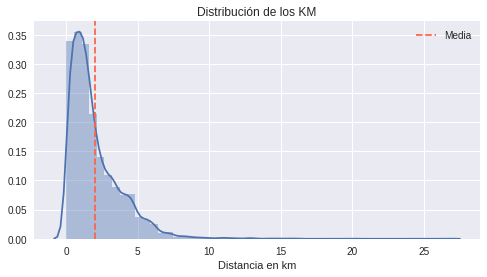

In [74]:
plt.figure(figsize=(8, 4))
sns.distplot(df_sin_imputaciones['distancia'], axlabel='Distancia en km')
plt.axvline(df_sin_imputaciones['distancia'].mean(), color = 'tomato', ls='--', label="Media")
plt.title("Distribución de los KM")
plt.legend();

La distancia en kms se encuentrean principalmente entre 0 y 5 kms, incluyendo datos que podemos considerar outliers (como 25 kms de distancia)

Distancia en km vs tiempo en minutos


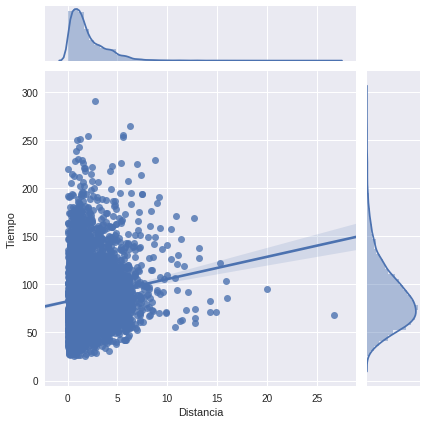

In [75]:
print("Distancia en km vs tiempo en minutos")
sns.jointplot(y='tiempo', x='distancia', data=df_sin_imputaciones, kind="reg")
plt.xlabel("Distancia")
plt.ylabel("Tiempo");

Hay una correlación positiva entre distancia y tiempo, sin embargo es baja y se puede deber a que no puede ser que hay otros atributos que afectan de forma más directa al tiempo, como el día y hora de la semana.

Por ejemplo, si aislamos el día domingo, a las 22 hrs, vemos una correlación positiva entre ambas variables, pero en otros casos esta variable parece no influir, como por ejemplo dia 1 y hora 22.

In [76]:
time = pd.DataFrame(df_sin_imputaciones['entrega'].str.split(':', expand=True))
time.columns = ('hora','minuto','segundos')

df_sin_imputaciones['hora'] = pd.to_numeric(time['hora'])

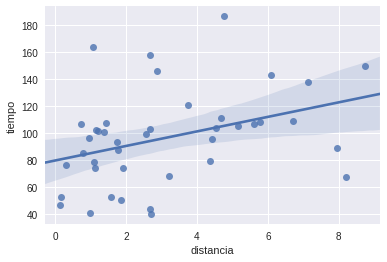

In [77]:
sns.regplot(data=df_sin_imputaciones.query("dia==0 and hora==22"), x='distancia', y='tiempo');

A diferencia del ejemplo anterior aislando el día lunes a la misma hora podemos observar que que la regresión tiende a ser levemente negativa, por lo cual no estamos tan seguro de que el día y la hora son variables relevantes que afecten al tiempo con respecto a la distancia.Ç

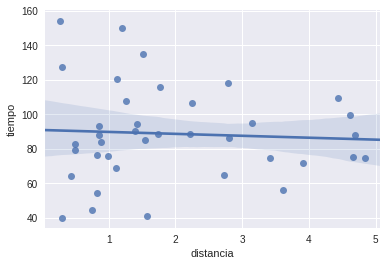

In [78]:
sns.regplot(data=df_sin_imputaciones.query("dia==1 and hora==22"), x='distancia', y='tiempo');

### A2.2 - Análisis de cantidad de productos por orden v/s tiempo de entrega

### A2.2.1 - Distribución de productos por orden

In [79]:
df_sin_imputaciones['pesaje'] = np.where(df['pesados'] >= 1, 1, 0)

La mayor cantidad de compras son de cantidades bajas de productos, con un promedio de 16.7 productos por pedido, lo que representa el ticket promedio de la compra de los clientes.

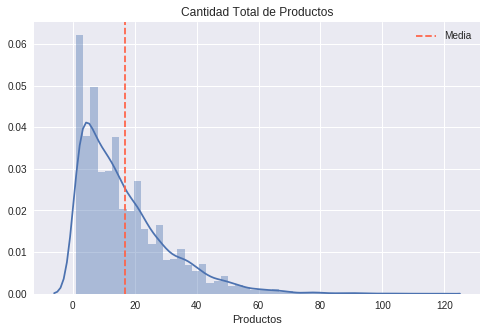

In [80]:
plt.figure(figsize=(8, 5))
sns.distplot(df_sin_imputaciones['cantidad_total'])
plt.axvline(df_sin_imputaciones['cantidad_total'].mean(), color='tomato', ls='--', label="Media")
plt.xlabel("Productos")
plt.title("Cantidad Total de Productos");
plt.legend();

In [81]:
print("Promedio de Productos por compra:", round(df['cantidad_total'].mean(), 2))

Promedio de Productos por compra: 16.73


Se puede observar que en las ordenes de compra mayormente los productos que solicitan son de tipo que deben ser pesados, lo que representa el __62%__ en los __KG__ y un __38%__ en __UN__.

In [82]:
df_sin_imputaciones['pesaje'].value_counts()

1    3595
0    2195
Name: pesaje, dtype: int64

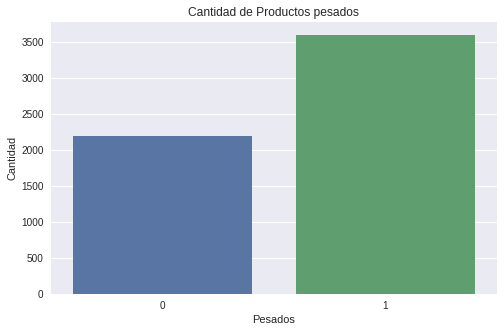

In [83]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_sin_imputaciones, x='pesaje')
plt.xlabel("Pesados")
plt.ylabel("Cantidad")
plt.title("Cantidad de Productos pesados");

El gráfico ademas nos muestra que aquellas compras que tienen productos que se deben pesar, tienen una distribución diferente a aquellos en los que no se pide ningun producto de pesaje, siendo su promedio mayor en aquellos que deben ser pesados. Se logra apreciar que en las compras con una cantidad hasta 10 productos, predomina los productos que no se pesan, es decir, estas compras chicas mayormente son productos por unidad, por otra parte, a medida que la cantidad de productos de una orden aumenta, los productos por unidad empiezan a decrecer y aumentan los productos que deben ser pesados.

<Figure size 720x360 with 0 Axes>

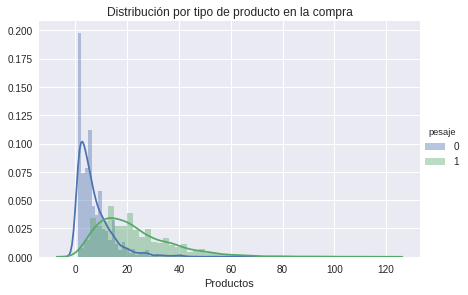

In [84]:
plt.figure(figsize=(10, 5))
g = sns.FacetGrid(df_sin_imputaciones, hue="pesaje", size=4, aspect=1.5)
g = g.map(sns.distplot, "cantidad_total")
g.add_legend()
plt.xlabel("Productos")
plt.title("Distribución por tipo de producto en la compra");

In [85]:
print("Promedio de productos en ordenes sin productos que deban ser pesados = ", round(df_sin_imputaciones.query("pesaje==0")['cantidad_total'].mean(), 2))
print("Promedio de productos en ordenes con productos que deban ser pesados = ", round(df_sin_imputaciones.query("pesaje==1")['cantidad_total'].mean(), 2))

Promedio de productos en ordenes sin productos que deban ser pesados =  7.14
Promedio de productos en ordenes con productos que deban ser pesados =  22.59


### A2.2.2 - Relación con el tiempo de entrega

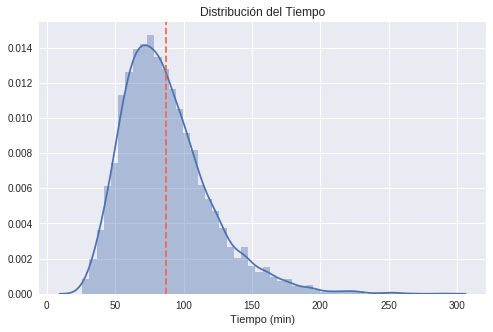

In [86]:
plt.figure(figsize=(8, 5))
sns.distplot(df_sin_imputaciones['tiempo'])
plt.xlabel("Tiempo (min)")
plt.axvline(df_sin_imputaciones['tiempo'].mean(), color='tomato', ls='--', label="Media")
plt.title("Distribución del Tiempo");

In [87]:
print("Promedio del tiempo de entrega:", round(df_sin_imputaciones['tiempo'].mean(), 2))

Promedio del tiempo de entrega: 86.99


El gráfico muestra evidencia para apoyar nuestra hipótesis, ya que se ve una correlación positiva entre la cantidad total de productos con el tiempo de entrega, es decir, a mayor cantidad de productos en una orden de compra, mayor tiempo en la entrega, lo que es algo lógico en este tipo de proceso de compras.

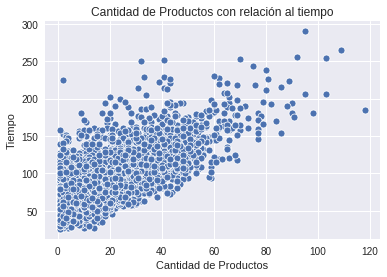

In [88]:
sns.scatterplot(data=df_sin_imputaciones, x='cantidad_total', y='tiempo')
plt.xlabel("Cantidad de Productos")
plt.ylabel("Tiempo")
plt.title("Cantidad de Productos con relación al tiempo");

### A2.3 - Calificación del repartidor v/s tiempo de entrega

La calificación del recolector se encuentra muy acotada entre los valores 4.50 y 5, haremos una prueba posterior con respecto al tiempo para saber que tan influyente o relevante puede ser.

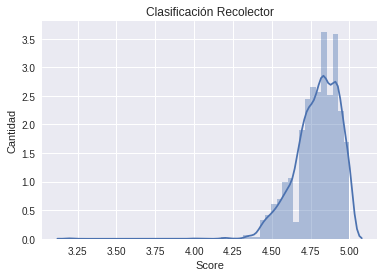

In [89]:
sns.distplot(df_sin_imputaciones.score_recolector)
plt.xlabel("Score")
plt.ylabel("Cantidad")
plt.title("Clasificación Recolector");

En el caso del "Rating" del repartidor, de momento el gráfico no nos permite saber si es influyente en el tiempo de entrega, sobre todo por el hecho de que la distribución de las calificaciones es muy acotada entre 4.50 y 5

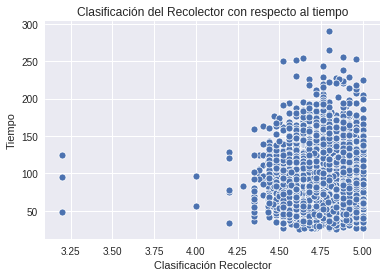

In [90]:
sns.scatterplot(data=df_sin_imputaciones, x='score_recolector', y='tiempo')
plt.xlabel("Clasificación Recolector")
plt.ylabel("Tiempo")
plt.title("Clasificación del Recolector con respecto al tiempo");

### A2.4 - Hora/Día de la semana v/s tiempo de entrega

### A2.4.1 - Hora

La Mayor cantidad de pedidos se concentra entre 10 y 13, cayendo hasta retomar desde las 19 a las 21 hrs

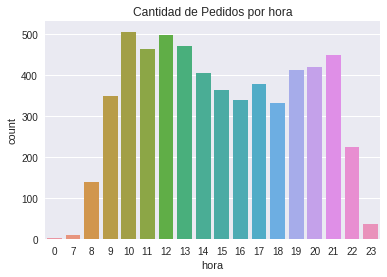

In [91]:
sns.countplot(data=df_sin_imputaciones, x='hora',).set_title('Cantidad de Pedidos por hora');

In [92]:
df_sin_imputaciones.groupby('hora').mean()['tiempo']

hora
0      74.654834
7      49.992801
8      75.386880
9      92.638187
10     85.860162
11     88.057951
12     86.113893
13     88.011048
14     89.563744
15     87.846318
16     83.758758
17     79.285798
18     86.844920
19     87.160881
20     84.746453
21     90.396917
22     92.929559
23    108.009700
Name: tiempo, dtype: float64

Revisando las horas, notamos que a las 9 hay un peak, al igual que a las 19 horas y luego pasado las 21 hrs

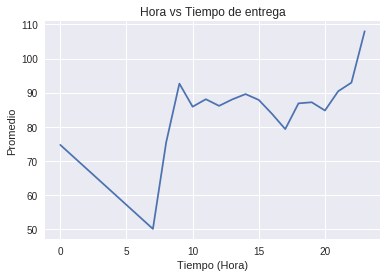

In [93]:
plt.plot(df_sin_imputaciones.groupby('hora').mean()['tiempo'])
plt.xlabel("Tiempo (Hora)")
plt.ylabel("Promedio")
plt.title('Hora vs Tiempo de entrega');

### A.2.4.2 - Dia de la semana

De Lunes a jueves se concentra la mayor cantidad de pedidos, siendo viernes a domingo los que tienen menos pedidos.

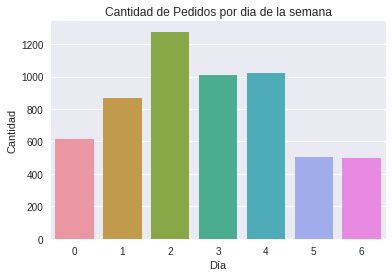

In [94]:
sns.countplot(data=df_sin_imputaciones, x='dia')
plt.xlabel("Día")
plt.ylabel("Cantidad")
plt.title('Cantidad de Pedidos por dia de la semana');

El tiempo de entrega es consistente con la cantidad de pedidos de cada día, excepto en el día jueves, donde es menor en promedio que la cantidad de pedidos del mismo día

In [95]:
df_sin_imputaciones.groupby('dia').mean()['tiempo']

dia
0    81.147438
1    90.756681
2    90.570261
3    88.816851
4    85.028184
5    84.869103
6    80.887471
Name: tiempo, dtype: float64

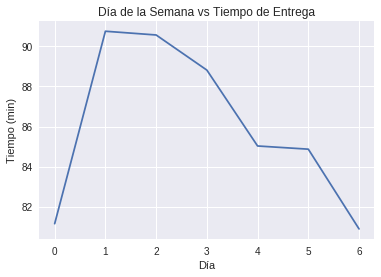

In [96]:
plt.plot(df_sin_imputaciones.groupby('dia').mean()['tiempo'])
plt.title('Día de la Semana vs Tiempo de Entrega')
plt.xlabel("Día")
plt.ylabel("Tiempo (min)");

### A2.4.3 - Día y Fecha

Notamos que diferentes días tienen diferentes peaks de tiempo de demora, por ejemplo, los dias lunes hay grandes tiempos de entrega entre 15 y 16, y luego entre 18 y 22. Por otro lado, el dia martes tiene altos tiempos de entrega duante la mañana. El dia miercoles a las 21 hrs tiene un tiempo de espera superlativamente mayor al resto de los dias.


In [97]:
table = pd.pivot_table(df_sin_imputaciones, values='tiempo', index=['hora'], columns=['dia'], aggfunc=np.mean)

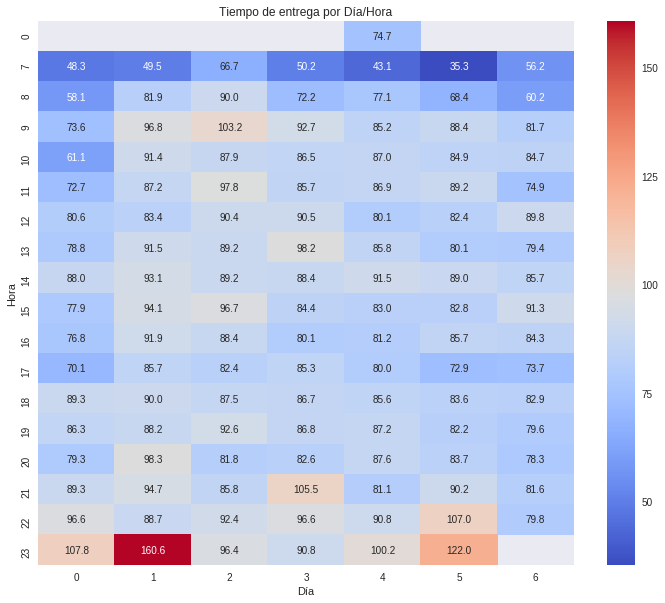

In [98]:
plt.figure(figsize=(12, 10))
sns.heatmap(table,annot=True, cmap='coolwarm', fmt=".1f")
plt.xlabel("Día")
plt.ylabel("Hora")
plt.title("Tiempo de entrega por Día/Hora");

### A.4 - Modelamiento con Dataset imputado

In [99]:
#Procedo a dividir la data en entrenamiento y validación
X = df_imputados.drop(columns='tiempo')
Y = df_imputados.pop('tiempo')

#Dividimos la data en 70/30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.30, random_state=123)

#Normalizamos la data
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

#### Implementamos los modelos:
1. LinearRegression
2. LassoCV
3. RidgeCV

#### 1.- Linear Regression

In [100]:
model_lr = LinearRegression().fit(X_train_scaled, y_train)
model_lr_pred = model_lr.predict(X_test_scaled)

In [101]:
print("MAE:", mean_absolute_error(y_test, model_lr_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, model_lr_pred)))

MAE: 22.4470171442638
RMSE: 31.89021474411099


In [102]:
#Buscando la mejor combinación de hiperparametros
fit_intercept = [True]
param_grid = dict(fit_intercept=fit_intercept)
gridsearch = GridSearchCV(LinearRegression(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=False)
result = gridsearch.fit(X_train_scaled, y_train)

In [103]:
print("Best Scoring: %f using: %s" %(result.best_score_, result.best_estimator_))

Best Scoring: 0.306611 using: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [104]:
model_lr_cv = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=-1, normalize=False)
model_lr_cv = model_lr_cv.fit(X_train_scaled, y_train)
model_lr_cv_pred = model_lr_cv.predict(X_test_scaled)

In [105]:
print("MAE:", mean_absolute_error(y_test, model_lr_cv_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, model_lr_cv_pred)))

MAE: 22.4470171442638
RMSE: 31.89021474411099


#### 2.- LassoCV

In [106]:
model_lasso = LassoCV().fit(X_train_scaled, y_train)
model_lasso_pred = model_lasso.predict(X_test_scaled)

In [107]:
print("MAE:", mean_absolute_error(y_test, model_lasso_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, model_lasso_pred)))

MAE: 22.451750411828687
RMSE: 31.889551140005736


#### 3.- RidgeCV

In [108]:
model_ridge = RidgeCV().fit(X_train_scaled, y_train)
model_ridge_pred = model_ridge.predict(X_test_scaled)

In [109]:
print("MAE:", mean_absolute_error(y_test, model_ridge_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, model_ridge_pred)))

MAE: 22.44981989871722
RMSE: 31.890609484090774


#### 4.- DecissionTreeRegressor

In [110]:
model_dtr = DecisionTreeRegressor().fit(X_train_scaled, y_train)
model_dtr_pred = model_dtr.predict(X_test_scaled)

In [111]:
print("MAE:", mean_absolute_error(y_test, model_dtr_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, model_dtr_pred)))

MAE: 34.42719553642384
RMSE: 47.06134214007179


In [112]:
%%time
#Implementación de GridSearch
max_features = list(range(1,X_train_scaled.shape[1]))
max_depth = np.linspace(1, 32, 32)
param_grid = dict(max_features= max_features, max_depth=max_depth)
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
result = grid_search.fit(X_train_scaled, y_train)

CPU times: user 2.03 s, sys: 79.9 ms, total: 2.11 s
Wall time: 16.3 s


In [113]:
print("Best Scoring: %f using: %s" %(result.best_score_, result.best_estimator_))

Best Scoring: 0.249010 using: DecisionTreeRegressor(criterion='mse', max_depth=4.0, max_features=10,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


In [114]:
model_dtr_cv = DecisionTreeRegressor(max_depth=4, max_features=13)
model_dtr_cv = model_dtr_cv.fit(X_train_scaled, y_train)
model_dtr_cv_pred = model_dtr_cv.predict(X_test_scaled)

In [115]:
print("MAE:", mean_absolute_error(y_test, model_dtr_cv_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, model_dtr_cv_pred)))

MAE: 24.34975140278517
RMSE: 33.60499461839941


#### 5.- RandomForestRegressor

In [116]:
model_rf = RandomForestRegressor().fit(X_train_scaled, y_train)
model_rf_pred = model_rf.predict(X_test_scaled)

In [117]:
print("MAE:", mean_absolute_error(y_test, model_rf_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, model_rf_pred)))

MAE: 25.2866960075191
RMSE: 34.29868041223241


In [118]:
# generamos una serie de listas para guardar los valores
tmp_oob_none, tmp_oob_sqrt, tmp_oob_log2 = [], [], []
n_estimators = range(20, 1000, 50)

In [119]:
# para cada rango de modelos estimados
for i in n_estimators:
    # Implementamos una variante con todos los atributos
    voting_rf_none = RandomForestRegressor(n_estimators= i,max_features=None,
                                       oob_score=True,
                                       random_state=123).fit(X_train_scaled, y_train)
    # Implementamos una variante donde los atributos se escogen con sqrt
    voting_rf_sqrt = RandomForestRegressor(n_estimators= i, max_features="sqrt",
                               warm_start=True,
                               oob_score=True,
                               random_state=123).fit(X_train_scaled, y_train)
    # Implementamos una variante donde los atributos se escogen con log
    voting_rf_log = RandomForestRegressor(n_estimators= i, max_features="log2",
                               warm_start=True,
                               oob_score=True,
                               random_state=123).fit(X_train_scaled, y_train)
    # Estimamos el error en OOB
    tmp_oob_none.append(1 - voting_rf_none.oob_score_)
    tmp_oob_sqrt.append(1 - voting_rf_sqrt.oob_score_)
    tmp_oob_log2.append(1 - voting_rf_log.oob_score_)
    


<Figure size 1152x216 with 0 Axes>

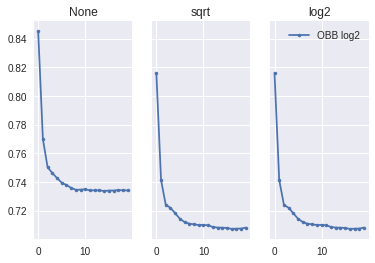

In [120]:
#Graficamos el comportamiento por cada variable
plt.figure(figsize=(16, 3));
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True);
axs[0].plot(tmp_oob_none, '.-', label="OBB None");
axs[0].set_title("None");
axs[1].plot(tmp_oob_sqrt, '.-', label= 'OBB sqrt');
axs[1].set_title("sqrt");
axs[2].plot(tmp_oob_log2, '.-', label="OBB log2");
axs[2].set_title("log2");
plt.legend();

In [121]:
#Ajustando hiperparametros en el modelo
model_rf_cv = RandomForestRegressor(max_features='log2', n_estimators=15, random_state=15)
model_rf_cv = model_rf_cv.fit(X_train_scaled, y_train)
model_rf_cv_pred = model_rf_cv.predict(X_test_scaled)

In [122]:
print("MAE:", mean_absolute_error(y_test, model_rf_cv_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, model_rf_cv_pred)))

MAE: 23.898188859840378
RMSE: 33.239775436609285


#### 6.- AdaBoostRegressor

In [123]:
model_adaboost = AdaBoostRegressor().fit(X_train_scaled, y_train)
model_adaboost_pred = model_adaboost.predict(X_test_scaled)

In [124]:
print("MAE:", mean_absolute_error(y_test, model_adaboost_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, model_adaboost_pred)))

MAE: 25.725866717517473
RMSE: 34.59039632994831


In [125]:
#Buscamos la mejor combinación de hiperparametros
learning_rate = [0.01, 0.1, 0.5]
n_estimators = [50, 100, 500, 1000, 2000]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
gridsearch = GridSearchCV(AdaBoostRegressor(), param_grid=param_grid, n_jobs=-1, cv=5, verbose=0)
result = gridsearch.fit(X_train_scaled, y_train)

In [126]:
print("Best scoring: %f using: %s" %(result.best_score_, result.best_estimator_))

Best scoring: 0.257939 using: AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='linear',
         n_estimators=50, random_state=None)


In [127]:
model_adaboost_cv = AdaBoostRegressor(learning_rate=0.01, n_estimators=50)
model_adaboost_cv = model_adaboost_cv.fit(X_train_scaled, y_train)
model_adaboost_cv_pred = model_adaboost_cv.predict(X_test_scaled)

In [128]:
print("MAE:", mean_absolute_error(y_test, model_adaboost_cv_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, model_adaboost_cv_pred)))

MAE: 24.01292321270627
RMSE: 32.935381098873904
